In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [2]:
from analysis_funcs import *

# Theta Definition

-> Tikz

# 1D Tracks

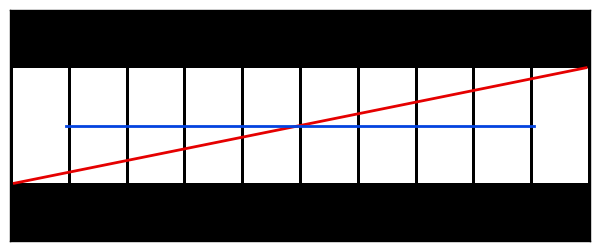

In [3]:
emptrow = list(np.zeros(201))
fullrow = np.ones(201)
fullrow[::20] = 0
fullrow = list(fullrow)
mytrack = np.array([emptrow,fullrow,fullrow,emptrow])

plt.plot([1,199],[0.5,2.5],color='xkcd:red',linewidth=2)

plt.plot([19,181],[1.5,1.5],color='xkcd:blue',linewidth=2)

plt.imshow(mytrack,aspect=20,cmap='gray',origin=[1,1])
plt.grid(False)
plt.tick_params(axis='both',left=False, bottom=False,labelleft=False,labelbottom=False)

plt.gcf().set_size_inches(7.5,3)

#plt.savefig("../docs/cat_documentation/images/postprocessing/1D_angle.pdf",bbox_inches='tight')

# 2D Fitting

In [4]:
def extract_track(obs, ii):
    """
    Extract and reshape a track from TrackObs obs at index ii.
    Output track is in units of electrons
    """
    return np.reshape(obs.data[ii]["TRACK"],(obs.data[ii]["DIM_AL"],obs.data[ii]["DIM_AC"]))*obs.gain

In [5]:
def linefunc_m(pars, x):
    """
    pars is an array of [slope,y0], the equation being slope*x + y0
    """
    return pars[0]*x + pars[1]

def angle_linefit_show(intrack, pixratio=1):
    """
    Showcase the line fitting algorithm. Returns the x and y arrays as well as the 
    """
    # the input track may have some rows/colums with zero values
    # remove those
    goodx = np.max(intrack,axis=1)>0
    goody = np.max(intrack,axis=0)>0
    track = intrack[np.where(goodx)[0],:]
    track = track[:,np.where(goody)[0]]
    
    dim0, dim1 = track.shape
    
    # We will form an x/y value pairs, with x being along axis 0, y being along axis 1
    # the values of the longer axis (i.e. more pixels) will just be the pixel coordinates
    # the values of the shorter axis will be the center of mass for each row/column
    
    from scipy.ndimage.measurements import center_of_mass
    
    if dim0 >= dim1:
        labels = np.zeros((dim0,dim1)) + np.transpose(np.array([range(dim0)]))
        cms = (center_of_mass(track, labels, range(dim0)))              
    else:
        labels = np.zeros((dim0,dim1)) + np.array([range(dim1)])
        cms = (center_of_mass(track, labels, range(dim1)))
        
    # set x and y from the centers of mass and subtract offset so the middle value is (0,0)
    x = (np.array([c[0] for c in cms]) - (dim0-1)/2)
    y = (np.array([c[1] for c in cms]) - (dim1-1)/2)* pixratio
    
    # TODO erros should be calculated more intelligently
    dx = np.zeros(x.shape)+0.5
    dy = np.zeros(y.shape)+pixratio/2
    
    # Estimation of the angle and the length

    ## Angle
    # get the slope via a fit

    from scipy import odr

    linemodel = odr.Model(linefunc_m)

    fitdat = odr.RealData(x, y, sx=dx, sy=dy)

    # give a rough starting value for theta
    slopestart = (y[-1]-y[0])/(max([x[-1]-x[0],1]))

    myodr = odr.ODR(fitdat, linemodel, beta0=[slopestart, 0.])
    myoutput = myodr.run()
    slope = myoutput.beta[0]
    sd_slope = myoutput.sd_beta[0]

    theta = np.arctan(slope) * 180/np.pi
    sd_theta = sd_slope/(1+slope**2) * 180/np.pi

    ## Length
    # pre-compute some exponents of the slope
    slope2 = slope**2
    slope4 = slope**4
    slope6 = slope**6
    # depending on which axis was used to fit, calculate the length differently
    if dim0>=dim1:
        tracklen = np.abs(x[-1]-x[0]) * np.sqrt(slope2+1)
        sd_tracklen = np.sqrt((slope2+1) * (dx[-1]**2+dx[0]**2)
                              + (x[-1]-x[0])**2 * (slope2/(1+slope2)) * sd_slope**2)
    else:
        tracklen = np.abs(y[-1]-y[0]) * np.sqrt(1+1/slope2)
        sd_tracklen = np.sqrt((1+1/slope2) * (dy[-1]**2+dy[0]**2)
                              + (y[-1]-y[0])**2 * 1/(slope4 + slope6)  * sd_slope**2)

            
    return x, y, dx, dy, myoutput.beta

In [24]:
# BAM
bin_AL = 1
bin_AC = 4
pixdepth = 38  # depletion zone depth in mum
obslist = read_Obslist_fits('../output/TrackObs/BAM/2015/10/31/BAM-OBS1_OBMT_START_63322239313925904.fits')

In [41]:
#stop = 1
stop = 6
ngood = 0

for obs in obslist:
    for ii in range(len(obs.data)):
        track = extract_track(obs,ii)
        if track.shape[0]>20 and track.shape[1]==4:
            ngood += 1
            if ngood == stop:
                goodtrack = track*obs.gain
track = goodtrack

x, y, dx, dy, params = angle_linefit_show(track,pixratio = 3*bin_AC/bin_AL)

dim0,dim1 = track.shape

slope = params[0]
ystart = params[1]

# set x and y to Gaia chip coordinates - need to adjust ystart accordingly
ystart += (dim1-1)/2 *3*bin_AC/bin_AL - slope*(dim0-1)/2

x += (dim0-1)/2
y += (dim1-1)/2 *3*bin_AC/bin_AL

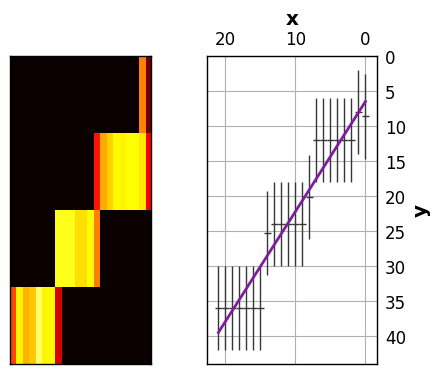

In [42]:
fig,axes = plt.subplots(ncols=2)
axes[0].imshow(np.flip(np.rot90(track),1)+1,origin='lower',aspect=12,
               norm=LogNorm(),cmap='hot',vmin = .5*np.min(track[track>0]),vmax=2*np.max(track))
#axes[0].colorbar()
axes[0].grid(False)
axes[0].tick_params(axis='both',left=False, bottom=False,labelleft=False,labelbottom=False)

axes[1].errorbar(x,y,xerr=dx,yerr=dy,linestyle='',color='xkcd:dark gray')
axes[1].plot(x,linefunc_m((slope,ystart),x),color='xkcd:purple',linewidth=2)
axes[1].invert_xaxis()
axes[1].invert_yaxis()
axes[1].set_aspect("equal")
#axes[1].grid(False)

    
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")
axes[1].xaxis.tick_top()
axes[1].xaxis.set_label_position('top')
axes[1].yaxis.tick_right()
axes[1].yaxis.set_label_position('right')



fig.set_size_inches(5,4)

#fig.savefig("../docs/cat_documentation/images/postprocessing/2D_fit.pdf",bbox_inches='tight')

# 2D bad tracks

In [43]:
#stop = 1
stop = 7
ngood = 0

for obs in obslist:
    for ii in range(len(obs.data)):
        track = extract_track(obs,ii)
        if track.shape[0]>20 and track.shape[1]==2:
            ngood += 1
            if ngood == stop:
                goodtrack = track*obs.gain
track = goodtrack

x, y, dx, dy, params = angle_linefit_show(track,pixratio = 3*bin_AC/bin_AL)

slope = params[0]
ystart = params[1]

# set x and y to Gaia chip coordinates - need to adjust ystart accordingly
ystart += (dim1-1)/2 *3*bin_AC/bin_AL - slope*(dim0-1)/2

x += (dim0-1)/2
y += (dim1-1)/2 *3*bin_AC/bin_AL

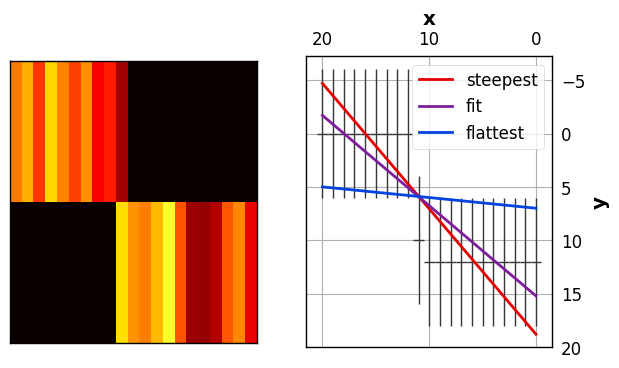

In [44]:
fig,axes = plt.subplots(ncols=2)

axes[0].imshow(np.flip(np.rot90(track),1)+1,origin='lower',aspect=12,
               norm=LogNorm(),cmap='hot',vmin = .5*np.min(track[track>0]),vmax=2*np.max(track))
#axes[0].colorbar()
axes[0].grid(False)
axes[0].tick_params(axis='both',left=False, bottom=False,labelleft=False,labelbottom=False)



plotx = x - np.min(x)
ploty = y - np.min(y)

axes[1].errorbar(plotx,ploty,xerr=dx,yerr=dy,linestyle='',color='xkcd:dark gray')

# steepest
steepslope = (y[0]-y[-1] + 2*dy[0])/(x[0] - x[-1] + 2*dx[0]) * .93
steepstart = 18.8
axes[1].plot(plotx,linefunc_m((steepslope,steepstart),plotx),label='steepest',color='xkcd:red',linewidth=2)

# best fit
bestslope = slope
beststart = ystart -  (np.min(y) - (bestslope*np.min(x)))
axes[1].plot(plotx,linefunc_m((bestslope,beststart),plotx),label='fit',color='xkcd:purple',linewidth=2)

# flattest
flatslope = -2/20
flatstart = 7
axes[1].plot(plotx,linefunc_m((flatslope,flatstart),plotx),label='flattest',color='xkcd:blue',linewidth=2)


axes[1].invert_xaxis()
axes[1].invert_yaxis()
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")
axes[1].xaxis.tick_top()
axes[1].xaxis.set_label_position('top')
axes[1].yaxis.tick_right()
axes[1].yaxis.set_label_position('right')

axes[1].set_aspect("equal")
axes[1].legend(loc='best')
#axes[1].grid(False)


fig.set_size_inches(7,4)

#plt.savefig("../docs/cat_documentation/images/postprocessing/2D_badfit.pdf",bbox_inches='tight')